<a href="https://colab.research.google.com/github/peterbabulik/synthetic/blob/main/Qantum_optimized_capacitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install cirq==0.15.0 --quiet

Using device: cuda
Initializing Quantum Capacitor Simulator...

Comparing baseline capacitor properties...


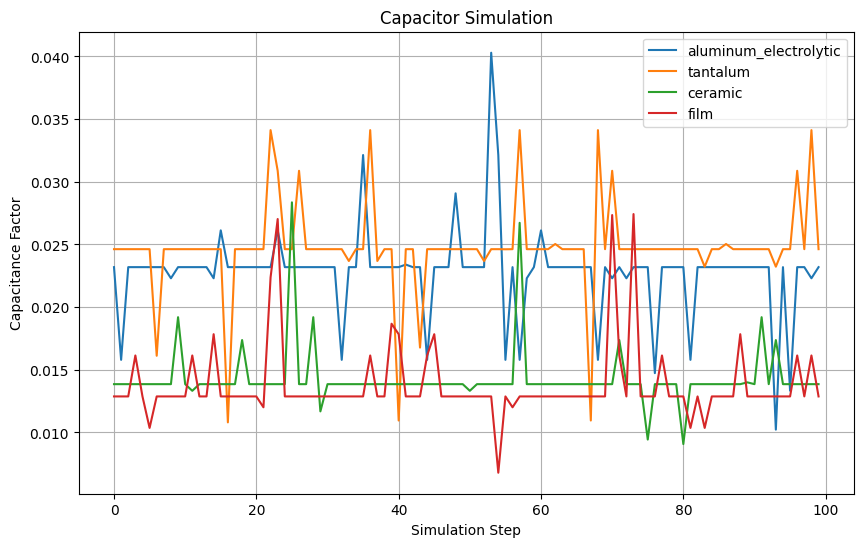

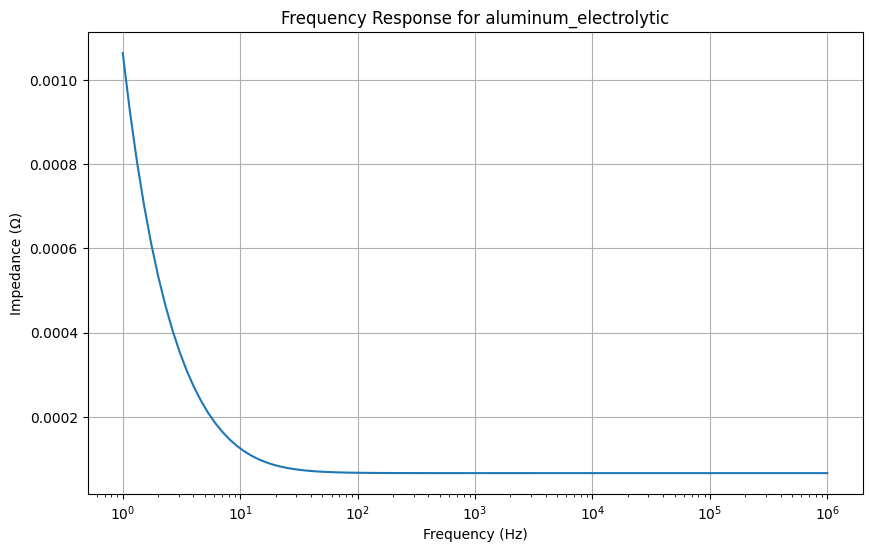

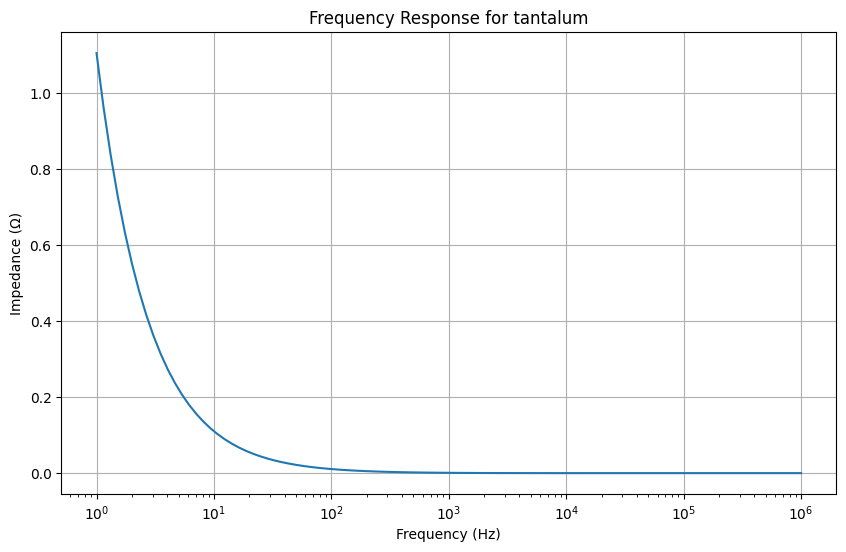

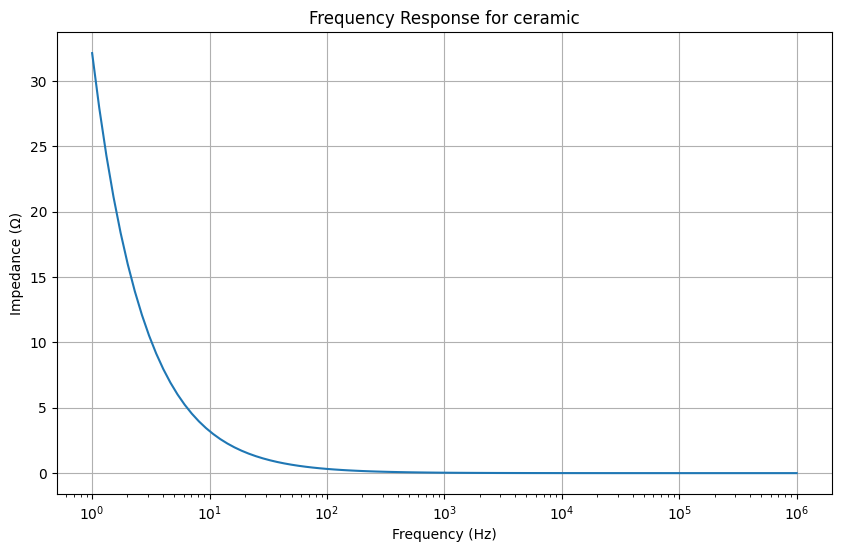

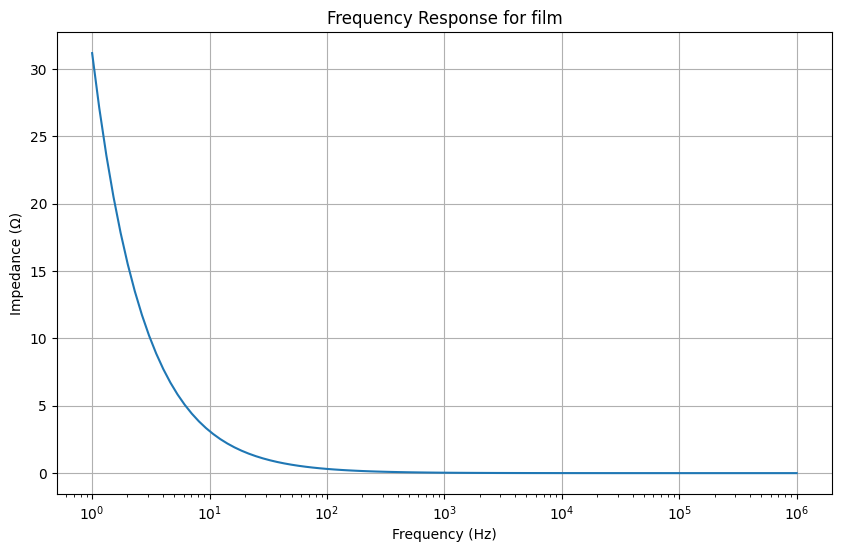


Optimizing aluminum_electrolytic properties...


Optimizing aluminum_electrolytic:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Q Factor: 0.46, Loss: 99.5378
Epoch 10, Q Factor: 0.46, Loss: 99.5378
Epoch 20, Q Factor: 0.46, Loss: 99.5378
Epoch 30, Q Factor: 0.34, Loss: 99.6593
Epoch 40, Q Factor: 0.34, Loss: 99.6593
Epoch 50, Q Factor: 0.46, Loss: 99.5378
Epoch 60, Q Factor: 0.46, Loss: 99.5378
Epoch 70, Q Factor: 0.45, Loss: 99.5514
Epoch 80, Q Factor: 0.46, Loss: 99.5378
Epoch 90, Q Factor: 0.46, Loss: 99.5378


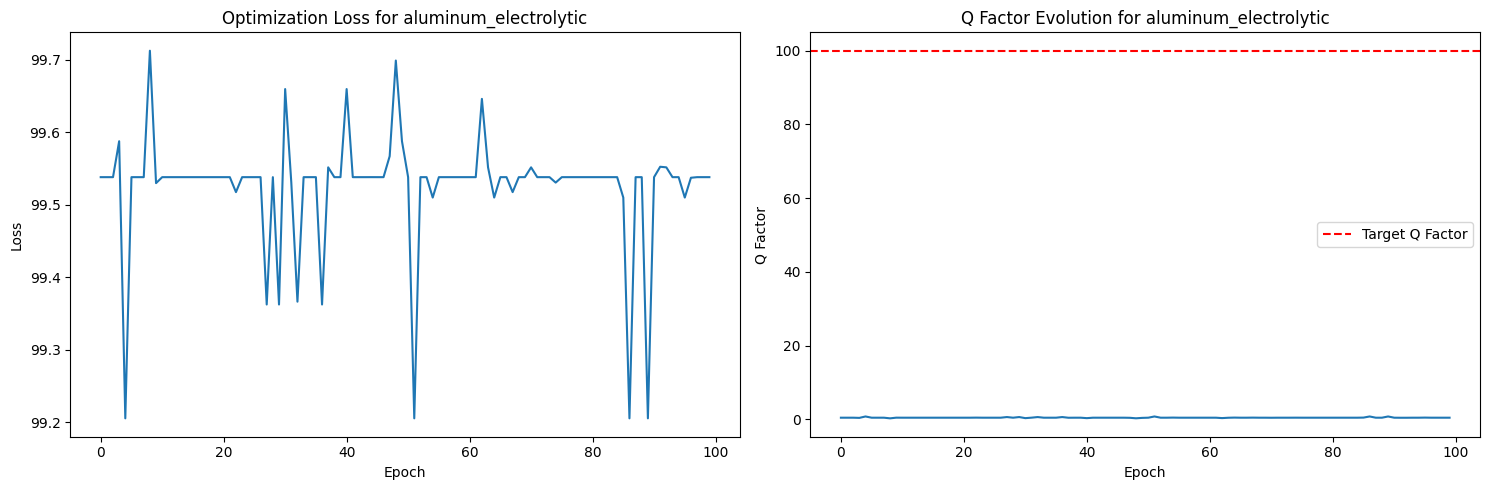


Optimizing tantalum properties...


Optimizing tantalum:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Q Factor: 58.79, Loss: 41.2118
Epoch 10, Q Factor: 92.17, Loss: 7.8283
Epoch 20, Q Factor: 92.17, Loss: 7.8283
Epoch 30, Q Factor: 92.17, Loss: 7.8283
Epoch 40, Q Factor: 92.17, Loss: 7.8283
Epoch 50, Q Factor: 92.17, Loss: 7.8283
Epoch 60, Q Factor: 92.17, Loss: 7.8283
Epoch 70, Q Factor: 92.17, Loss: 7.8283
Epoch 80, Q Factor: 58.79, Loss: 41.2118
Epoch 90, Q Factor: 77.54, Loss: 22.4595


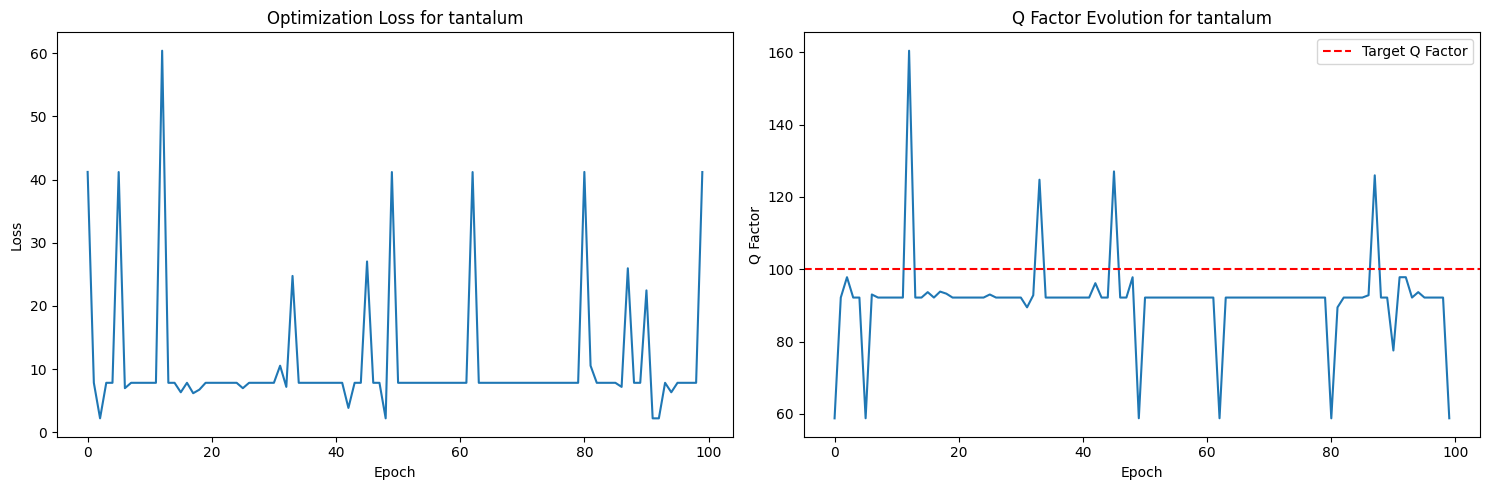


Optimizing ceramic properties...


Optimizing ceramic:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Q Factor: 7717.48, Loss: 7617.4790
Epoch 10, Q Factor: 7717.48, Loss: 7617.4790
Epoch 20, Q Factor: 7717.48, Loss: 7617.4790
Epoch 30, Q Factor: 7998.71, Loss: 7898.7065
Epoch 40, Q Factor: 7998.71, Loss: 7898.7080
Epoch 50, Q Factor: 7717.48, Loss: 7617.4785
Epoch 60, Q Factor: 7717.48, Loss: 7617.4785
Epoch 70, Q Factor: 7717.48, Loss: 7617.4785
Epoch 80, Q Factor: 6309.00, Loss: 6208.9990
Epoch 90, Q Factor: 7717.48, Loss: 7617.4790


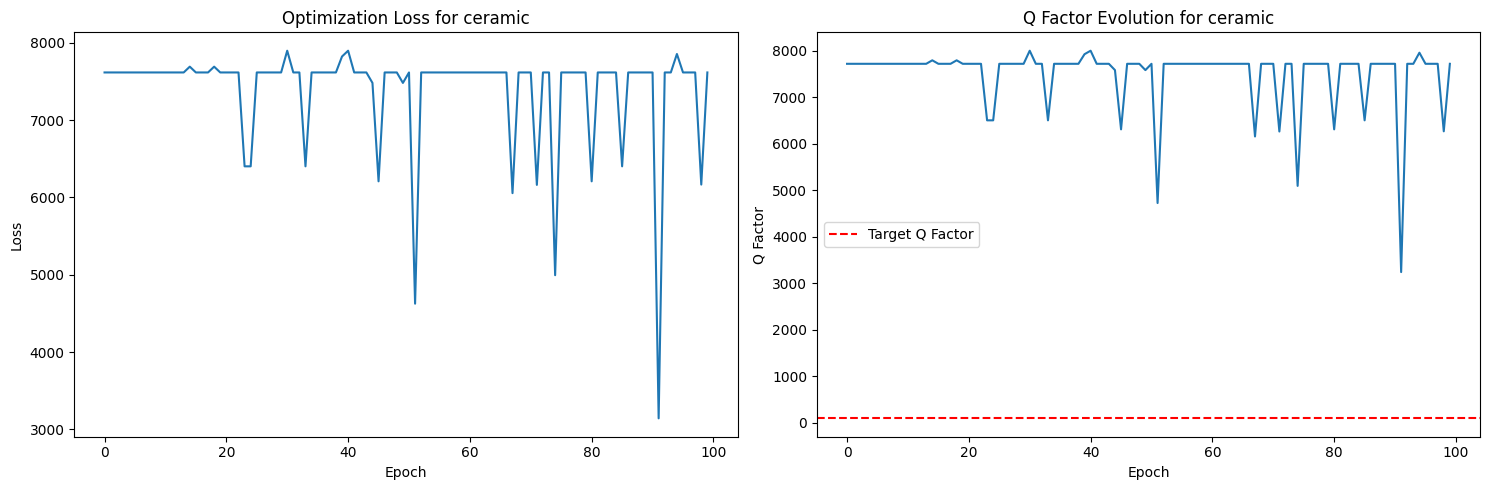


Optimizing film properties...


Optimizing film:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Q Factor: 8126.48, Loss: 8026.4834
Epoch 10, Q Factor: 7845.26, Loss: 7745.2578
Epoch 20, Q Factor: 7845.26, Loss: 7745.2578
Epoch 30, Q Factor: 8044.08, Loss: 7944.0786
Epoch 40, Q Factor: 7845.26, Loss: 7745.2578
Epoch 50, Q Factor: 7845.26, Loss: 7745.2578
Epoch 60, Q Factor: 7845.26, Loss: 7745.2578
Epoch 70, Q Factor: 7845.26, Loss: 7745.2578
Epoch 80, Q Factor: 7845.26, Loss: 7745.2578
Epoch 90, Q Factor: 7845.26, Loss: 7745.2578


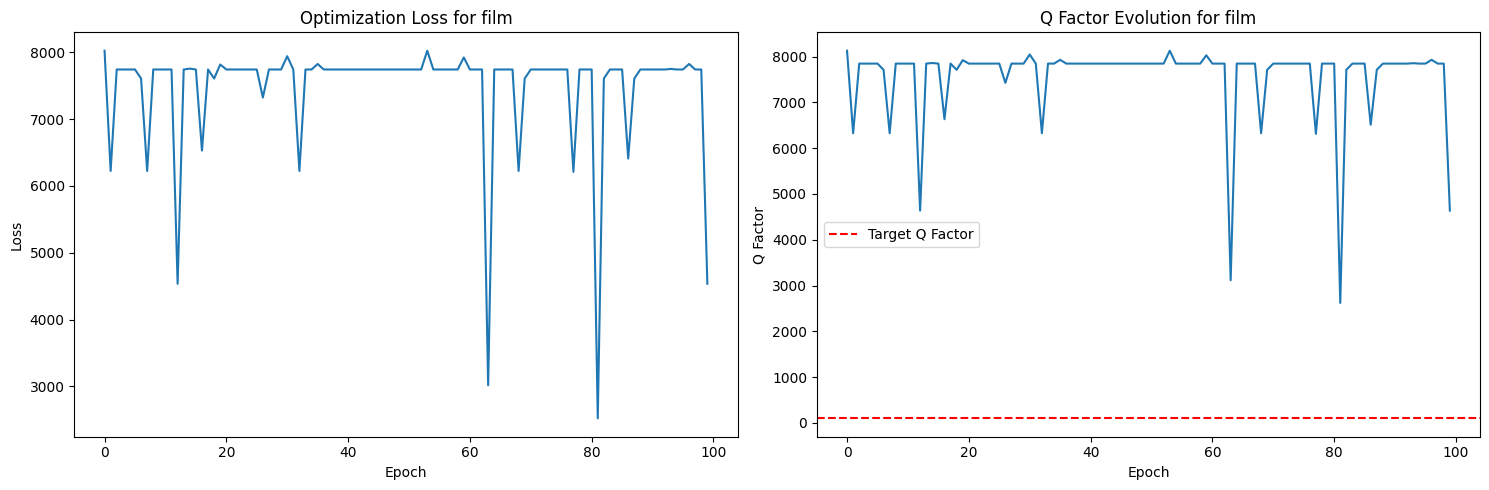


Comparing optimized capacitor properties...


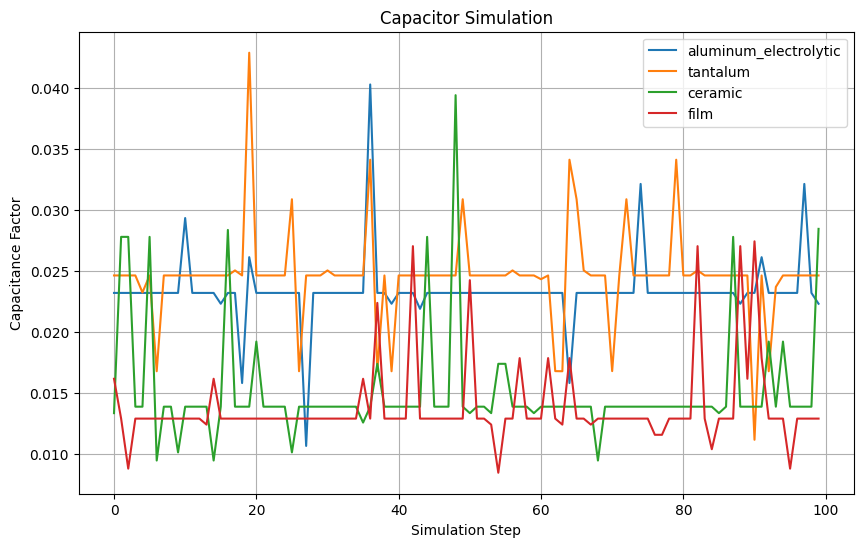

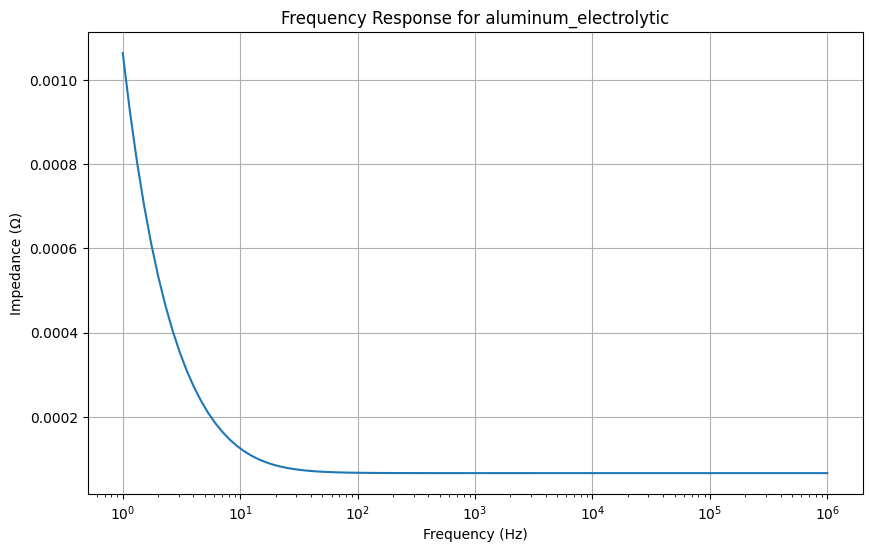

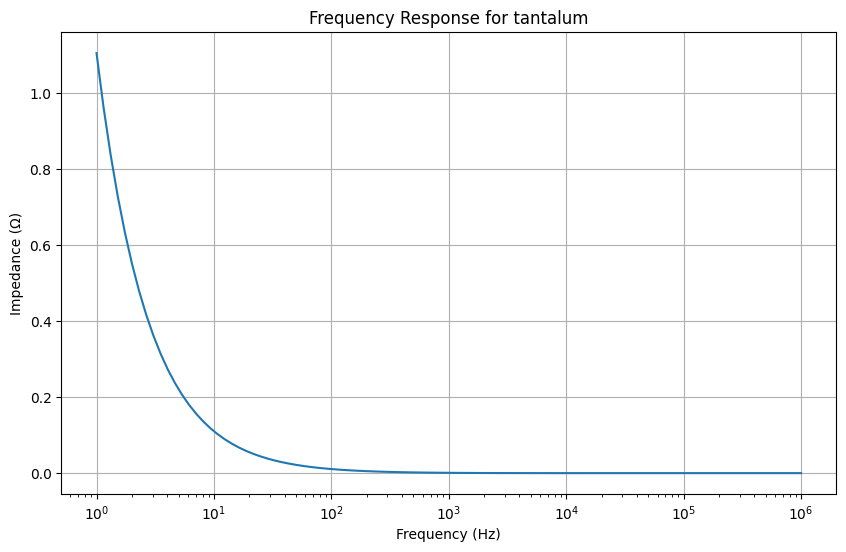

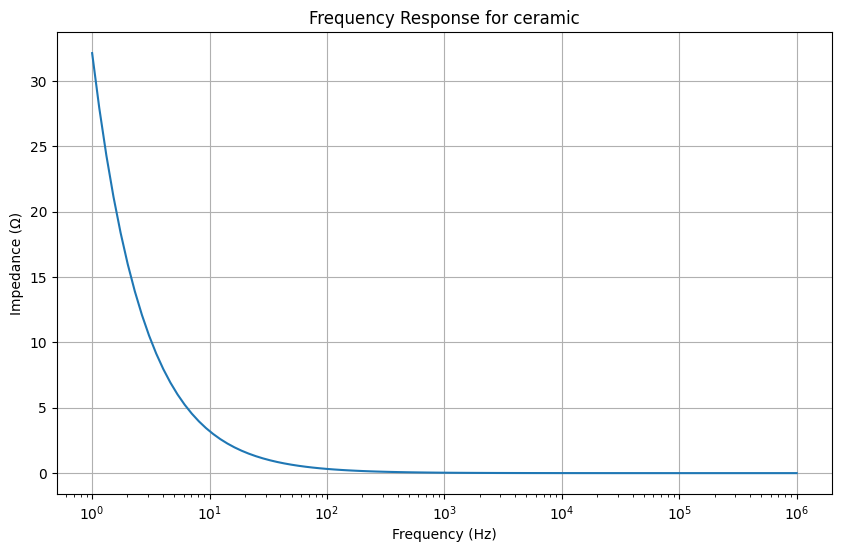

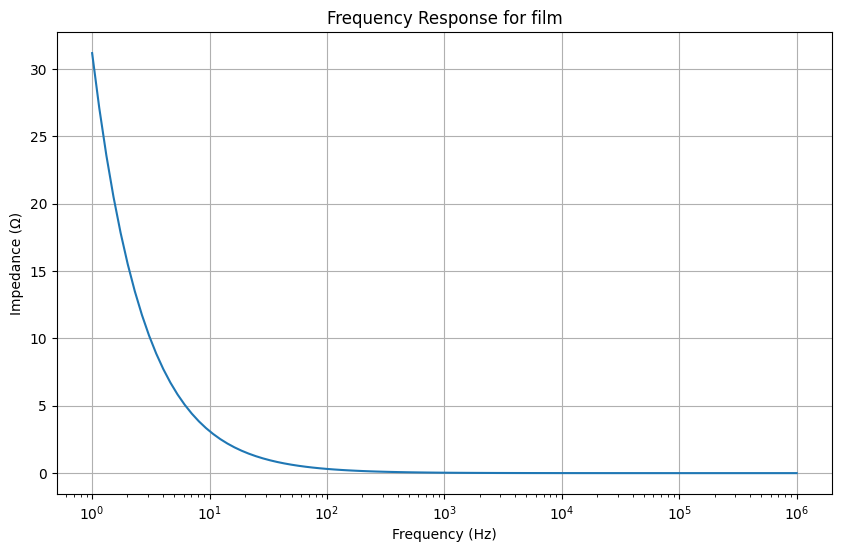

In [4]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CapacitorProperties:
    def __init__(self):
        self.properties = {
            'aluminum_electrolytic': {
                'capacitance_range': (0.1, 1000000),  # μF
                'voltage_range': (6.3, 450),  # V
                'esr_range': (0.01, 0.1),  # Ω
                'leakage_current': 0.01,  # μA/μF·V
                'lifetime': 2000,  # hours at 85°C
                'temperature_range': (-55, 105)  # °C
            },
            'tantalum': {
                'capacitance_range': (0.1, 1000),  # μF
                'voltage_range': (2.5, 50),  # V
                'esr_range': (0.05, 0.5),  # Ω
                'leakage_current': 0.005,  # μA/μF·V
                'lifetime': 10000,  # hours at 85°C
                'temperature_range': (-55, 125)  # °C
            },
            'ceramic': {
                'capacitance_range': (1e-6, 100),  # μF
                'voltage_range': (25, 1000),  # V
                'esr_range': (0.01, 0.1),  # Ω
                'leakage_current': 0.001,  # μA/μF·V
                'lifetime': 50000,  # hours at 85°C
                'temperature_range': (-55, 125)  # °C
            },
            'film': {
                'capacitance_range': (1e-3, 100),  # μF
                'voltage_range': (50, 2000),  # V
                'esr_range': (0.01, 0.1),  # Ω
                'leakage_current': 0.002,  # μA/μF·V
                'lifetime': 100000,  # hours at 85°C
                'temperature_range': (-55, 125)  # °C
            }
        }

    def get_property(self, capacitor_type, property_name):
        return self.properties.get(capacitor_type, {}).get(property_name, 0)

    def get_normalized_properties(self, capacitor_type):
        props = self.properties[capacitor_type]
        scaler = MinMaxScaler()

        numerical_props = {k: np.mean(v) if isinstance(v, tuple) else v
                           for k, v in props.items() if isinstance(v, (int, float, tuple))}

        normalized_values = scaler.fit_transform(np.array(list(numerical_props.values())).reshape(-1, 1)).flatten()
        return dict(zip(numerical_props.keys(), normalized_values))

class QuantumCircuitDesigner:
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
        self.qubits = cirq.LineQubit.range(num_qubits)

    def amplitude_encoding(self, values, qubits):
        norm = np.sqrt(sum(x**2 for x in values))
        normalized_values = [x/norm for x in values]

        circuit = cirq.Circuit()
        for i, value in enumerate(normalized_values):
            if i < len(qubits):
                angle = 2 * np.arccos(value)
                circuit.append(cirq.ry(angle)(qubits[i]))
        return circuit

    def phase_encoding(self, values, qubits):
        circuit = cirq.Circuit()
        for i, value in enumerate(values):
            if i < len(qubits):
                circuit.append(cirq.rz(2 * np.pi * value)(qubits[i]))
        return circuit

class QuantumCapacitorSimulator:
    def __init__(self, num_qubits=6):
        self.num_qubits = num_qubits
        self.capacitor_properties = CapacitorProperties()
        self.circuit_designer = QuantumCircuitDesigner(num_qubits)
        self.qubits = cirq.LineQubit.range(num_qubits)

        self.theta = torch.nn.Parameter(torch.randn(num_qubits, device=device, requires_grad=True))
        self.phi = torch.nn.Parameter(torch.randn(num_qubits, device=device, requires_grad=True))
        self.gamma = torch.nn.Parameter(torch.randn(num_qubits, device=device, requires_grad=True))

        self.optimizer = torch.optim.Adam([self.theta, self.phi, self.gamma], lr=0.01)
        self.noise_model = cirq.depolarize(p=0.01)

    def create_capacitor_circuit(self, capacitor_type):
        circuit = cirq.Circuit()
        props = self.capacitor_properties.get_normalized_properties(capacitor_type)

        circuit += self.circuit_designer.amplitude_encoding(
            [props['capacitance_range'], props['voltage_range'], props['esr_range']], self.qubits[:3])
        circuit += self.circuit_designer.phase_encoding(
            [props['leakage_current'], props['lifetime'], props['temperature_range']], self.qubits[3:6])

        for i, qubit in enumerate(self.qubits):
            circuit.append(cirq.ry(float(self.theta[i]))(qubit))
            circuit.append(cirq.rz(float(self.phi[i]))(qubit))
            circuit.append(cirq.rx(float(self.gamma[i]))(qubit))

        for i in range(0, self.num_qubits - 1, 2):
            circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i + 1]))

        return circuit

    def simulate_capacitor(self, capacitor_type, steps=100):
        circuit = self.create_capacitor_circuit(capacitor_type)
        noisy_circuit = circuit.with_noise(self.noise_model)
        simulator = cirq.Simulator()

        results = []
        for _ in range(steps):
            result = simulator.simulate(noisy_circuit)
            state_vector = result.final_state_vector
            capacitance_factor = np.abs(np.mean(state_vector[:len(state_vector)//2]))
            results.append(capacitance_factor)

        return results

    def calculate_quality_factor(self, capacitor_type):
        circuit = self.create_capacitor_circuit(capacitor_type)
        noisy_circuit = circuit.with_noise(self.noise_model)
        simulator = cirq.Simulator()

        result = simulator.simulate(noisy_circuit)
        state_vector = result.final_state_vector

        esr = self.capacitor_properties.get_property(capacitor_type, 'esr_range')[0]
        capacitance = self.capacitor_properties.get_property(capacitor_type, 'capacitance_range')[1]
        frequency = 1000  # Assume 1 kHz as a reference frequency

        impedance = 1 / (2 * np.pi * frequency * capacitance * 1e-6)
        q_factor = impedance / esr

        quantum_factor = np.sum(np.abs(state_vector) ** 2 * np.arange(len(state_vector)))
        quality_tensor = torch.tensor(q_factor * quantum_factor,
                                      device=device, dtype=torch.float32, requires_grad=True)
        return quality_tensor

    def simulate_frequency_response(self, capacitor_type, freq_range=(1, 1e6), points=100):
        frequencies = np.logspace(np.log10(freq_range[0]), np.log10(freq_range[1]), points)
        impedances = []

        circuit = self.create_capacitor_circuit(capacitor_type)
        simulator = cirq.Simulator()

        capacitance = self.capacitor_properties.get_property(capacitor_type, 'capacitance_range')[1]
        esr = self.capacitor_properties.get_property(capacitor_type, 'esr_range')[0]

        for freq in frequencies:
            result = simulator.simulate(circuit)
            state_vector = result.final_state_vector

            xc = 1 / (2 * np.pi * freq * capacitance * 1e-6)
            z = np.sqrt(esr**2 + xc**2)

            quantum_factor = np.abs(np.mean(state_vector))
            impedance = z * quantum_factor
            impedances.append(impedance)

        return frequencies, impedances

class CapacitorOptimizer:
    def __init__(self, quantum_simulator):
        self.quantum_simulator = quantum_simulator
        self.target_quality_factor = 100

    def loss_function(self, predicted_q, target_q):
        return torch.abs(predicted_q - torch.tensor(target_q, device=device, dtype=torch.float32))

    def optimize_capacitor(self, capacitor_type, epochs=100):
        losses = []
        q_factors = []

        for epoch in tqdm(range(epochs), desc=f"Optimizing {capacitor_type}"):
            self.quantum_simulator.optimizer.zero_grad()

            q_factor = self.quantum_simulator.calculate_quality_factor(capacitor_type)
            loss = self.loss_function(q_factor, self.target_quality_factor)

            loss.backward()
            self.quantum_simulator.optimizer.step()

            losses.append(loss.item())
            q_factors.append(q_factor.item())

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Q Factor: {q_factor.item():.2f}, Loss: {loss.item():.4f}")

        return losses, q_factors

class ResultsVisualizer:
    @staticmethod
    def plot_optimization_results(losses, q_factors, capacitor_type):
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        plt.plot(losses)
        plt.title(f'Optimization Loss for {capacitor_type}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(122)
        plt.plot(q_factors)
        plt.axhline(y=100, color='r', linestyle='--', label='Target Q Factor')
        plt.title(f'Q Factor Evolution for {capacitor_type}')
        plt.xlabel('Epoch')
        plt.ylabel('Q Factor')
        plt.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_frequency_response(frequencies, impedances, capacitor_type):
        plt.figure(figsize=(10, 6))
        plt.semilogx(frequencies, impedances)
        plt.title(f'Frequency Response for {capacitor_type}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Impedance (Ω)')
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_capacitance_simulation(simulation_data, capacitor_types):
        plt.figure(figsize=(10, 6))
        for capacitor_type, data in simulation_data.items():
            plt.plot(data, label=capacitor_type)
        plt.title('Capacitor Simulation')
        plt.xlabel('Simulation Step')
        plt.ylabel('Capacitance Factor')
        plt.legend()
        plt.grid(True)
        plt.show()

def compare_capacitors(quantum_simulator, capacitor_types):
    simulation_results = {}
    q_factor_results = {}
    freq_response_results = {}

    for capacitor_type in capacitor_types:
        simulation_results[capacitor_type] = quantum_simulator.simulate_capacitor(capacitor_type)
        q_factor = quantum_simulator.calculate_quality_factor(capacitor_type)
        q_factor_results[capacitor_type] = q_factor.item()

        frequencies, impedances = quantum_simulator.simulate_frequency_response(capacitor_type)
        freq_response_results[capacitor_type] = (frequencies, impedances)

    return simulation_results, q_factor_results, freq_response_results

def main():
    print("Initializing Quantum Capacitor Simulator...")
    quantum_simulator = QuantumCapacitorSimulator()
    optimizer = CapacitorOptimizer(quantum_simulator)
    visualizer = ResultsVisualizer()

    capacitor_types = ['aluminum_electrolytic', 'tantalum', 'ceramic', 'film']

    print("\nComparing baseline capacitor properties...")
    simulation_results, q_factor_results, freq_response_results = compare_capacitors(quantum_simulator, capacitor_types)

    visualizer.plot_capacitance_simulation(simulation_results, capacitor_types)

    for capacitor_type in capacitor_types:
        visualizer.plot_frequency_response(freq_response_results[capacitor_type][0],
                                           freq_response_results[capacitor_type][1],
                                           capacitor_type)

    for capacitor_type in capacitor_types:
        print(f"\nOptimizing {capacitor_type} properties...")
        losses, q_factors = optimizer.optimize_capacitor(capacitor_type, epochs=100)
        visualizer.plot_optimization_results(losses, q_factors, capacitor_type)

    print("\nComparing optimized capacitor properties...")
    simulation_results, q_factor_results, freq_response_results = compare_capacitors(quantum_simulator, capacitor_types)

    visualizer.plot_capacitance_simulation(simulation_results, capacitor_types)

    for capacitor_type in capacitor_types:
        visualizer.plot_frequency_response(freq_response_results[capacitor_type][0],
                                           freq_response_results[capacitor_type][1],
                                           capacitor_type)

if __name__ == "__main__":
    main()